# `Gen` Experiments
# II. Gaussian Mixture Model

(c) David Merrell

In [1]:
using Gen
using PyPlot

## Model

In this notebook we'll build a Gaussian mixture model, condition it on some (simulated) data, and infer the posterior distribution of the cluster centers.

We'll assume the number of components (clusters) is known.
Note: If we didn't know the number of clusters, then we could use some other model -- e.g., Dirichlet Process clustering. I have another notebook for that.

For simplicity's sake, we'll assume the clusters all have equal probability.
(Otherwise we would use a Dirichlet prior to model the differing cluster probabilities).

In [2]:
@gen function gauss_mix(n_clusters::Int64, n_samples::Int64)
    
    cluster_means = [@trace(normal(0.0, 10.0), :means => i) for i=1:n_clusters]
    cluster_spreads = [@trace(gamma(2.0, 1.0), :spreads => i) for i=1:n_clusters]
    cluster_probs = fill(1.0/n_clusters, n_clusters)
    
    z = zeros(n_samples, 1)
    
    for j=1:n_samples
        c = @trace(categorical(cluster_probs), :cluster => j)
        z[j] = @trace(normal(cluster_means[c], cluster_spreads[c]), :z => j)
    end
    
    return z

end;

## Sanity check: simulate & visualize

In [3]:
n_data = 1000
n_clusters = 4
    
tr = simulate(gauss_mix, (n_clusters, n_data))
dataset = [tr[:z => j] for j=1:n_data];

In [4]:
function plot_choices(zs, means, assignments)
    
    z_vecs = [zs[assignments .== i] for i=1:length(unique(assignments))]
    hist(z_vecs, Int(round(sqrt(n_data))), histtype="barstacked", normed=true)

    for (i, mean) in enumerate(means)
        plot([mean; mean], [0; n_data], color="k")
    end
    
end;


function plot_trace(tr)
    
    zs = [tr[:z => j] for j=1:n_data];
    means = [tr[:means => i] for i=1:n_clusters];
    assignments = [tr[:cluster => j] for j=1:n_data]
    
    plot_choices(zs, means, assignments)

end;

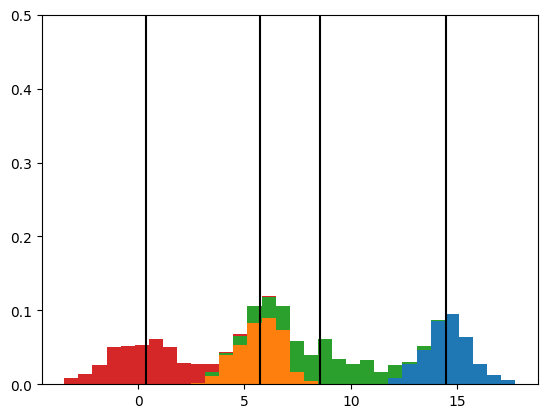

In [5]:
plot_trace(tr)
ylim(0,0.5)
show()

## Gaussian mixture models are difficult

The Gaussian mixture model poses some challenges for Bayesian inference.
* Identifiability issues:
    - Cluster labeling is arbitrary. That is: when we sample cluster locations multiple times, there is ambiguity regarding which location belongs to which hidden gaussian.
    - If two hidden gaussians are located very near each other -- i.e., the distance between their means is much smaller than either of their standard deviations -- then they will be practically indistinguishable. (This seems more like a mathematical curiosity than a practical modeling issue; if our inference method consistently yields co-located clusters, then we're probably assuming too many clusters.)
    - Michael Betancourt (one of the brains behind Stan) wrote a nice post about these issues: https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html. I recommend reading it if you get a chance. His solution, in essence, consists of using very strong priors. We will use a different strategy -- one that highlights the power of Gen's "programmable inference" design philosophy.
* Sampling challenges:
    - If we use something very naive -- like importance sampling -- to infer posteriors on the locations, then we will have very inefficient inference. The probability of $k$ randomly sampled locations each landing near a hidden gaussian is very small. 
    - If we do something smarter, like Metropolis-Hastings, then we have another set of issues to deal with -- multimodality. Think of it this way: if we have $k$ cluster locations going on a random walk, then there is little probability that each of the hidden gaussians will end up with exactly one of them. It's more probable that some gaussians will end up with more than one of our randomly-walking locations, and that other hidden gaussians will end up with none. But these non-optimal arrangements are still local maxima in probability, so it will be difficult to escape those arrangements and find the correct one.  


## Solution: Heuristic-guided sampling

There are strategies to solve these problems:
* We can keep the sampled locations in sorted order. Since the hidden gaussians must themselves be ordered, this establishes an unambiguous assignment of sampled locations to hidden gaussians.
    - Note: this idea of "sorting" relies on the fact that we have 1-dimensional data. However, we can extend this strategy to higher dimensions by using a *linear assignment* to map new samples to old samples, maintaining a consistent assignment from the samples to regions of space.
* We can ameliorate the multimodality of MCMC by using a heuristic to *guide* our sampling toward regions of high probability. For example, we can use K-means clustering to initialize *and periodically reset* our markov chain.
    - Note: K-means may also fall prey to multi-modality. However, it is a relatively inexpensive heuristic that allows us to efficiently visit the different modes (even if they're far away from each other).
    - Note: if you're wondering why it's okay to use a heuristic like K-means during MCMC, see this excellent preprint: https://arxiv.org/abs/1801.03612 
* Putting this all together: our inference strategy will consist of
    1. Metropolis-Hastings over cluster locations;
    2. Gibbs sampling over cluster assignments;
    3. Occasional importance resampling, guided by K-means, in order to reset the markov chain (typically at a different mode).
    
This should yield fairly efficient sampling, and at the same time avoid getting trapped in any modes.

So our inference task requires a highly specialized sampling strategy. 
Most PPLs would have difficulty managing this.
In contrast, `Gen`'s "programmable inference" philosophy handles it perfectly.

### A simple K-means implementation

In [6]:
using Statistics

function mean_update(data, cluster_assignments, k)
    return [mean(data[cluster_assignments .== i]) for i=1:k]
end

function cluster_update(data, means)
    
    dists = map(abs, data .- transpose(means))
    min_inds = argmin(dists, dims=2)
    
    return [min_inds[i][2] for i=1:length(min_inds)]
end


function kmeans(data::Array{Float64,1}, k::Int64, max_iter::Int64=1000)
    
    # random initialization
    cluster_assignments = zeros(size(data)[1])
    means = rand(data, k)
    
    i = 1
    while i <= max_iter
        
        cluster_assignments = cluster_update(data, means)
        new_means = mean_update(data, cluster_assignments, k)
        
        if new_means == means
            break
        end
        
        means = new_means
        i += 1
        
    end
    
    # Sort the means in order to ameliorate
    # identifiability issues.
    srt_inds = sortperm(means)
    inv_map = zeros(size(srt_inds))
    for (i, ind) in enumerate(srt_inds)
        inv_map[ind] = i
    end
    ca = map(x->inv_map[x], cluster_assignments)
    
    return means[srt_inds], ca
end

kmeans (generic function with 2 methods)

### Proposal distributions (and other functions for updating the trace)

Our inference procedure will rely on these functions to generate samples.

In [7]:
# This proposal uses k-means to propose new cluster locations
# and cluster assignments. 
# It will be used to occasionally "reset" the markov chain.
@gen function resampling_proposal(n_clusters, dataset, noise)
    
    means, assignments = kmeans(dataset, n_clusters)
    spreads = zeros(n_clusters)
    for i=1:n_clusters
        means[i] = @trace(normal(means[i], noise), :means => i)
        spreads[i] = @trace(gamma(2.0,1.0), :spreads => i)
    end
    
    for j=1:length(dataset)
        unnorm_probs = [ abs(exp(-0.5* (dataset[j] - means[i])^2 / (spreads[i]^2) ) / spreads[i]) for i=1:n_clusters]
        @trace(categorical(unnorm_probs ./ sum(unnorm_probs)), :cluster => j)
    end
    
end


# A proposal distribution for the cluster locations
@gen function mh_mean_proposal(tr, n_clusters)
    for i=1:n_clusters
        @trace(normal(tr[:means => i], 0.1), :means => i)
    end
end


# We simply resample the clusters' standard deviations
@gen function mh_spread_proposal(tr, n_clusters)
    for i=1:n_clusters
        @trace(gamma(1.0, 1.0), :spreads => i)
    end
end

# A quick Gibbs update for the cluster assignments.
# This is a "true" Gibbs update -- no Metropolis-Hastings involved.
# We know the exact distributions of the cluster assignments 
# when all other variables are held fixed.
function cluster_assignment_gibbs_update(tr, n_clusters, n_data)
    
    # The cluster assignments only ever interact with the 
    # cluster centers in sorted order.
    centers = [tr[:means => i] for i=1:n_clusters]
    srt_inds = sortperm(centers)
    centers = centers[srt_inds]
    spreads = [tr[:spreads => i] for i=1:n_clusters][srt_inds]
    
    new_assignments = Gen.choicemap()
    
    for j=1:n_data
        unnorm_probs = [ exp(-0.5* (tr[:z => j] - centers[i])^2 / (spreads[i]^2)) / spreads[i] for i=1:n_clusters]
        new_assignments[:cluster => j] = categorical(unnorm_probs ./ sum(unnorm_probs))
    end
    
    new_tr, _, _, _ = Gen.update(tr, (n_clusters, n_data), (), new_assignments)
    return new_tr
    
end


# This represents one step of the MCMC sampler.
# Think of this as the "default" sampling strategy, 
# which occasionally gets reset by the k-means-guided
# importance resampling.
function mcmc_sample(tr, n_clusters, n_data)
    
    tr, _ = Gen.mh(tr, mh_mean_proposal, (n_clusters,))
    tr, _ = Gen.mh(tr, mh_spread_proposal, (n_clusters,))
    tr = cluster_assignment_gibbs_update(tr, n_clusters, n_data)
    
    return tr
end

mcmc_sample (generic function with 1 method)

## Our inference program

Consists of the following parts:
* Generate a trace; condition it on observations; and use K-means to initialize it near a promising configuration.
* For each sample:
    - with some small probability, reset the trace with K-means.
    - Perform some "thinning" steps;
    - store the posterior quantities of interest.

In [8]:
function guided_mcmc_inference(dataset, n_clusters, n_samples, mcmc_thinning=10, p_reset=0.1)
    
    # These will store quantities of interest
    means = zeros(n_samples, n_clusters)
    spreads = zeros(n_samples, n_clusters)
    n_data = size(dataset)[1]
    assignments = zeros(n_data, n_clusters)
    
    # Load the observations into the model
    observations = Gen.choicemap()
    for j=1:n_data
        observations[:z => j] = dataset[j]
    end
    
    # Generate an initial trace; immediately use the 
    # k-means heuristic to get it situated nicely.
    tr, _ = Gen.generate(gauss_mix, (n_clusters, n_data), observations)
    tr, _ = Gen.importance_resampling(gauss_mix, (n_clusters, n_data), observations,
                                      resampling_proposal, (n_clusters, dataset, 0.25), 3)
    
    
    # Now enter the main sampling loop.
    for s=1:n_samples
        
        # possibly perform a reset.
        reset = Gen.bernoulli(p_reset)
        if reset
            tr, _ = Gen.importance_resampling(gauss_mix, (n_clusters, n_data), observations,
                                              resampling_proposal, (n_clusters, dataset, 0.25), 3)
        end
        
        # Let the random walk run for  a little bit
        for t=1:mcmc_thinning
            tr = mcmc_sample(tr, n_clusters, n_data)
        end
        
        # Get the quantities of interest from the trace
        for i=1:n_clusters
            means[s,i] = tr[:means => i]
            spreads[s,i] = tr[:spreads => i]
        end
        for j=1:n_data
            assignments[j,tr[:cluster => j]] += 1
        end
    end
        
    return means, spreads, assignments
end

guided_mcmc_inference (generic function with 3 methods)

In [9]:
means, spreads, assignments = guided_mcmc_inference(dataset, n_clusters, 1000, 10, 0.05);

## Visualize the results

For now, we'll just plot histograms of the sampled cluster locations.

Have we recovered the means of the hidden gaussians?

In [10]:
function plot_location_posteriors(means)
    hist(means, Int(round(sqrt(size(means)[1]))), histtype="barstacked", normed=true)
end

plot_location_posteriors (generic function with 1 method)

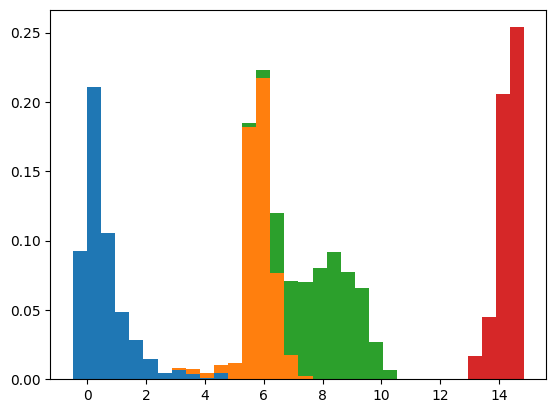

In [11]:
plot_location_posteriors(means)
show()

Excellent! These posteriors correspond very nicely to the means of the hidden gaussians.

We'll re-plot the simulated dataset, for illustration:

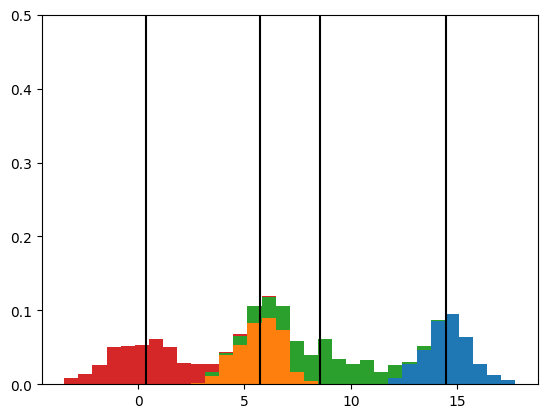

In [13]:
plot_trace(tr)
ylim(0,0.5)
show()

The colors don't matter -- what's important is that each posterior has a mode very near the hidden gaussian means.